In [2]:
from mistralai import Mistral
import numpy as np 
import matplotlib.pyplot as plt 
import base64
import io
import os

import random
import sympy as sp
from scipy import integrate
from sympy.parsing.sympy_parser import parse_expr


In [ ]:

def get_and_save_plot(send_to_api = False):

    def generate_expression(depth: int = 3) -> sp.Expr:
        x = sp.Symbol("x")
        constants = [random.randint(-10, 10)] + [0,0,1,-1,2,-2]
        unary_funcs = [sp.sin, sp.cos, sp.exp, sp.log, sp.sqrt]
        binary_ops = [(lambda a, b: a + b), (lambda a, b: a - b), 
                    (lambda a, b: a * b), (lambda a, b: a / (b + 1e-5)), 
                    (lambda a, b: a ** sp.Rational(1, b + 1))]
        polynomial_ops = [()]

        if depth == 0:
            return x * random.choice(constants) + x
        
        if random.random() < 0.2:
            power = random.choice([-2, -1.5, -1, -0.5, 0.5, 1, 2, 3])
            return x**power
        
        if random.random() < 0.3:
            func = random.choice(unary_funcs)
            return func(generate_expression(depth - 1))

        op = random.choice(binary_ops)
        left = generate_expression(depth - 1)
        right = generate_expression(depth - 1)
        try:
            return op(left, right)
        except: 
            return left if random.random() < 0.5 else right 

    random_function = generate_expression(random.choice([2,3]))
    simplified_function = sp.simplify(random_function)
    print(simplified_function)
    f = sp.lambdify(sp.Symbol('x'), simplified_function, "numpy")
    xs = np.arange(-7,7)
    plt.plot(xs, f(xs))
    
    if not send_to_api:
        return simplified_function
    buffer = io.BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)

    image_base64 = base64.b64encode(buffer.read()).decode('utf-8')
    
    prompt = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Reply only with what you determine to be the equation for the function generating this graph in the format f(x) = [equation]"},
                {"type": "image", "image_url": {"url": f"data:image/png;base64,{image_base64}"}}
            ]
        }
    ]
    client = Mistral(api_key="aMqfK42eOv1z58hmk6dhlTfnPjbbZnKZ")
    model = "mistral-small-latest"
    response = client.chat.complete(
        model=model,
        messages=prompt
    )
    
    return response.message




x*(x**2 - 2)


x*(x**2 - 2)

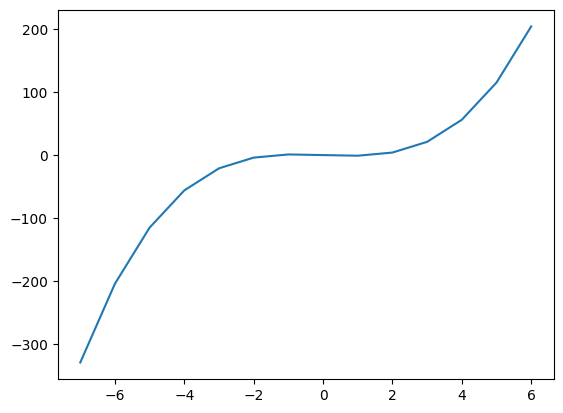

In [4]:
get_and_save_plot()

In [ ]:
def integral_difference(func1_expr, func2_expr, lower_bound=-10, upper_bound=10):
    expr1 = func1_expr.split("=")[1].strip() if "=" in func1_expr else func1_expr
    expr2 = func2_expr.split("=")[1].strip() if "=" in func2_expr else func2_expr
    
    x = sp.Symbol('x')
    expr1_sympy = parse_expr(expr1, local_dict={'x': x})
    expr2_sympy = parse_expr(expr2, local_dict={'x': x})
    print(expr1_sympy)
    print(expr2_sympy)
    simplified_function = sp.simplify(expr1_sympy)
    f = sp.lambdify(sp.Symbol('x'), simplified_function, "numpy")
    xs = np.arange(-10,10)
    plt.plot(xs, f(xs))
    simplified_function = sp.simplify(expr2_sympy)
    f = sp.lambdify(sp.Symbol('x'), simplified_function, "numpy")
    xs = np.arange(-10,10)
    plt.plot(xs, f(xs))
    integral1 = sp.integrate(expr1_sympy, (x, lower_bound, upper_bound))
    integral2 = sp.integrate(expr2_sympy, (x, lower_bound, upper_bound))
    
    return abs(float(integral1 - integral2))

def function_mse(expr1, func2_expr, num_points=1000, lower_bound=-10, upper_bound=10, func1_as_string = False):
    x = sp.Symbol('x')
    if func1_as_string:
        expr1 = expr1.split("=")[1].strip() if "=" in expr1 else expr1
    expr2 = func2_expr.split("=")[1].strip() if "=" in func2_expr else func2_expr
    
    f1 = sp.lambdify(x, parse_expr(expr1), "numpy")
    f2 = sp.lambdify(x, parse_expr(expr2), "numpy")
    
    points = np.linspace(lower_bound, upper_bound, num_points)
    
    values1 = f1(points)
    values2 = f2(points)
    
    squared_diffs = np.square(values1 - values2)
    mse = np.mean(squared_diffs)
    
    return np.sqrt(mse)

integral_difference("sin(x)/(x**2 + 1.0e-5)", "sin(x) * exp(-0.5*x**2)", 100)

sin(x)/(x**2 + 1.0e-5)


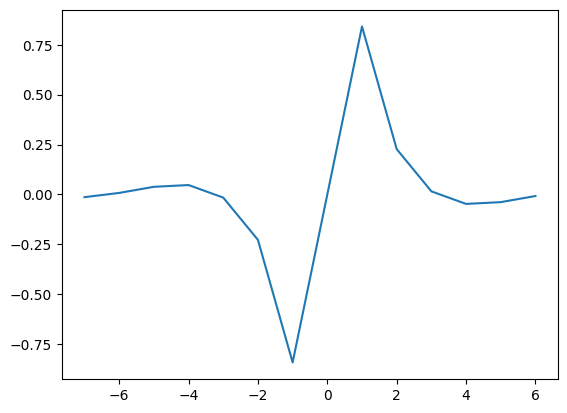

In [14]:
expr1 = str(get_and_save_plot())

In [ ]:
expr2 = "sin(x) * exp(-0.5*x**2)"
function_mse(expr1, expr2, 100, func1_as_string=True)
#Add Wasserstein

np.float64(1.4659217101203756)